In [1]:
import ssl
ssl._create_default_https_context = ssl._create_unverified_context

In [2]:
import torch
import torch.optim
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import torchvision
import torch.utils.data
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import matplotlib.pyplot as plt
from tqdm import tqdm
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")   # use GPU if available

## **Warmup Exercises**

In [3]:
# create a random tensor
x = torch.randn(3,5,5)
x

tensor([[[ 0.4087, -0.8977, -0.5590,  2.0335,  1.0063],
         [ 1.8984, -0.2633,  0.0252,  1.7775,  0.5284],
         [-0.4471,  0.8396, -1.3039,  1.2150,  1.7191],
         [-0.1944, -1.1533,  0.4767, -0.0801,  1.3584],
         [ 1.3358,  1.1212, -0.9982,  1.9079,  0.2062]],

        [[ 1.5582, -1.2031,  0.5682,  0.8463, -0.3713],
         [-1.6906, -0.2856,  0.5294,  0.3256, -2.0775],
         [ 1.4707,  0.8503,  0.1308, -0.9875, -0.4715],
         [ 0.8590,  1.0694, -0.5381, -0.8723, -0.4405],
         [-1.1014, -2.4246,  1.3078,  0.9617, -0.1486]],

        [[-0.6786, -1.2791, -0.8645,  1.0667, -0.1196],
         [-0.6891, -0.6406,  1.5202,  1.5707, -0.7599],
         [ 0.0390,  1.3539,  0.5610, -2.1026, -0.3495],
         [-0.5113, -0.9394,  0.8939,  0.4001, -0.6020],
         [ 1.3717,  0.9289,  0.7351, -0.8939,  0.2392]]])

In [4]:
x.shape

torch.Size([3, 5, 5])

What will be the output of a Max Pooling Operation (using [torch.nn.functional.max_pool2d](https://pytorch.org/docs/stable/generated/torch.nn.functional.max_pool2d.html)) with a kernal size of 3x3 and a stride of 2?

In [5]:
result = F.max_pool2d(x, 3, 2)
print(result)
print(result.shape)

tensor([[[1.8984, 2.0335],
         [1.3358, 1.9079]],

        [[1.5582, 0.8463],
         [1.4707, 1.3078]],

        [[1.5202, 1.5707],
         [1.3717, 0.8939]]])
torch.Size([3, 2, 2])


Now do the same but using [nn.MaxPool2d](https://pytorch.org/docs/stable/generated/torch.nn.MaxPool2d.html). Do you get the same result?

In [6]:
maxpool_layer = nn.MaxPool2d(kernel_size=3, stride=2)
result = maxpool_layer(x)
print(result)
print(result.shape)

tensor([[[1.8984, 2.0335],
         [1.3358, 1.9079]],

        [[1.5582, 0.8463],
         [1.4707, 1.3078]],

        [[1.5202, 1.5707],
         [1.3717, 0.8939]]])
torch.Size([3, 2, 2])


See [this](https://ezyang.github.io/convolution-visualizer/) for a nice visualization of convolution

Now we will explore using the [nn.Conv2D](https://pytorch.org/docs/stable/generated/torch.nn.Conv2d.html) funtion. It takes the following parameters: 
<br>
`nn.Conv2d(in_channels, out_channels, kernel_size, stride=1, padding=0, dilation=1)`

In [11]:
# create a random RGB tensor of size 10x10
x = torch.rand(4,10,10)

In [12]:
x.shape

torch.Size([4, 10, 10])

In [17]:
# apply a convolutional layer with 5 filters, each of size 3x3, with a stride of 1. What will be the shape?
conv_layer = nn.Conv2d(4, 5, 3, stride=1)
print(conv_layer(x).shape)

torch.Size([5, 8, 8])


The spatial dimension has reduced to 8x8. Why? Can you fix it so that the spatial dimension does not change?
<br>
<br>
**Recall**: Formula for *same padding*: $\dfrac{kernel size - 1}{2}$

In [18]:
conv_layer = nn.Conv2d(4, 5, 3, stride=1, padding = 1)
print(conv_layer(x).shape)

torch.Size([5, 10, 10])


What is the shape of the weights for the convolutional layer?

In [19]:
print(conv_layer.weight.shape)

torch.Size([5, 4, 3, 3])


Now assume you have an input with a batch size of 16, 20 channels, and a spatial dimension of 100x60. You want your resulting output tensor after Max Pooling to be of shape (16, 20, 25, 25). What parameters of the Max Pooling would you choose?

In [15]:
input = torch.randn(16, 20, 100, 100)

maxpool_layer = nn.MaxPool2d(kernel_size=4, stride=4)
output1 = maxpool_layer(input)
print(output1.shape)

torch.Size([16, 20, 25, 25])


Can you achieve the same thing but using the stride of a convolution operator instead?

In [16]:
conv_layer = nn.Conv2d(20, 20, 3, stride=4, padding = 1)
output2 = conv_layer(input)
print(output2.shape)

torch.Size([16, 20, 25, 25])


### Convolutional Networks

#### Part 1: Data Pre-processing

1. Data Transforms

Use [torchvision.transforms](https://pytorch.org/vision/0.9/transforms.html) as a reference. Apply data transformations to the training images such that you
- Crop a random portion of image and resize it to a size of 32x32
- Apply random horizantal flipping as a data augmentation strategy. You can check other data augmentations [here](https://pytorch.org/vision/main/auto_examples/transforms/plot_transforms_illustrations.html#sphx-glr-auto-examples-transforms-plot-transforms-illustrations-py)
- Transform it to a PyTorch Tensor with scaled values between 0-1
- Standardize it such that it has a mean of zero and standard deviation of 1

For the test images, only perform the last two steps

Note: 
- The mean of the CIFAR dataset for each of the RGB Channels is: `(0.4914, 0.4822, 0.4465)`
- The standard deviation of the CIFAR dataset for each of the RGB channels is: `(0.2023, 0.1994, 0.2010)`

In [21]:
transform_train = transforms.Compose([transforms.RandomResizedCrop(32),
                                      transforms.RandomHorizontalFlip(),
                                      transforms.ToTensor(),
                                      transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))])

transform_test = transforms.Compose([transforms.ToTensor(),
                                     transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))])

We will work with the CIFAR10 dataset. It is a dataset of 60,000 32x32 colour images in 10 classes, with 6000 images per class. There are 50,000 training images and 10,000 test images.

2. Load (and download if you havent already done so) the training and testing datasets using [torchvision.datasets](https://pytorch.org/vision/main/generated/torchvision.datasets.CIFAR10.html). Specify the transforms that you have already defined in the previous step. 

In [22]:
trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train)
testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_test)

Files already downloaded and verified
Files already downloaded and verified


3. Define your data loader. Use a batch size of 128 for training and 100 for testing. Make sure you shuffle the data loading process in the training set!

In [23]:
trainloader = torch.utils.data.DataLoader(trainset, batch_size=128, shuffle=True)
testloader = torch.utils.data.DataLoader(testset, batch_size=100, shuffle=False)

Let's visualize some of the images from the dataset

In [24]:
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

def imshow(inp):
    """Display image from a PyTorch Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.4914, 0.4822, 0.4465])
    std = np.array([0.2023, 0.1994, 0.2010])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    return inp

In [28]:
# get some random training images
images, labels = next(iter(trainloader))
print(images.shape)
print(labels.shape)

torch.Size([128, 3, 32, 32])
torch.Size([128])


In [29]:
# let's have a look at the labels for the first 4 loaded images 
print(labels[:4])
# if we would like to map them to human-readble text labels
print(', '.join([classes[labels[b]] for b in range(4)]))

tensor([5, 9, 6, 4])
dog, truck, frog, deer


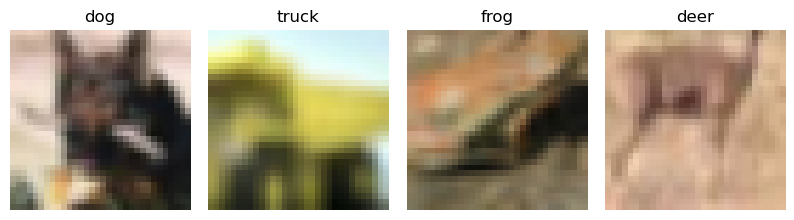

In [30]:
num_images_to_show = 4
fig, axs = plt.subplots(1, num_images_to_show, figsize=(10,10))
np.vectorize(lambda ax:ax.axis('off'))(axs)

for j in range(num_images_to_show):
    axs[j].imshow(imshow(images[j]))
    axs[j].set_title(classes[labels[j].item()])
    
plt.subplots_adjust(wspace=0.1, hspace = 0)

#### Part 2: Defining the Convolutional Network

Implement a CNN architecture as described below:

- Use three convolutional layers, each with a filter size of 3x3. Make sure you preserve the spatial dimension after each convolutional operation. The first two convolutional opertation are followed by Max Pooling of (2x2) with a stride of 2. Please use ReLU as an activation funtion. 
- The number of channels of each output convolutional layer should gradually increase to 126 throught the training. 
- The final convolutional layer is followed by **global** average pooling
- The resulting features is fed into a fully-connecetd layer which maps the features into 64 features (use a ReLU activation funtion and Dropout with a drop probability of 0.1)
- The final 64 features are fed into the classifier

**Note**: You need to keep track of the channels and spatial dimensions of the resulting outputs after each step, because you will need to define the dimension of the fully-connected layers!

In [37]:
class CNN(nn.Module):  
    def __init__(self, increase_factor = 42):
        super().__init__()
        # define all the layer we need. They do not have to be in order here. 
        self.conv1 = nn.Conv2d(3, increase_factor, 3, 1)    # 
        self.conv2 = nn.Conv2d(increase_factor, increase_factor * 2, 3, 1)
        self.conv3 = nn.Conv2d(increase_factor * 2, increase_factor * 3, 3, 1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc = nn.Linear(increase_factor * 3, 64)
        self.classifier = nn.Linear(64, 10)
        self.dropout = nn.Dropout(0.1)

    def forward(self, x):   # (N, 3, 32, 32)
        x = self.pool(F.relu(self.conv1(x)))   # (N, 42, 32, 32) --> pool --> (N, 42, 16, 16) 
        x = self.pool(F.relu(self.conv2(x)))   # (N, 84, 16, 16) --> pool --> (N, 42, 8, 8) 
        x = F.relu(self.conv3(x))              # (N, 126, 8, 8)
        x = x.mean(dim = [-1, -2])             # (N, 126)
        x = self.dropout(F.relu(self.fc(x)))   # (N, 64)
        x = self.classifier(x)                 # (N, 10)
        return x

Create an instance of your model and run it with a random tensor to ensure there is no error. Also check that the output shape is (N, 10) where N is your batch size. **Note**: If you are using a GPU, make sure to move both your model AND input tensor to the GPU device

In [38]:
model = CNN().to(device)
random_input = torch.randn(1,3,32,32).to(device)
print(model(random_input).shape)

torch.Size([1, 10])


Refer to the [torch.optim](https://pytorch.org/docs/stable/optim.html) library. Define the optimizer and learning rate. Use SGD with momentum, with an initial learning rate of 0.01

In [ ]:
optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

Define the learning rate scheduler (use [cosine annealing](https://pytorch.org/docs/stable/generated/torch.optim.lr_scheduler.CosineAnnealingLR.html#torch.optim.lr_scheduler.CosineAnnealingLR)) and plot the learning rate variation for 100 epochs. 

In [ ]:
epochs = 100
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=epochs)

lrs = []
for _ in range(epochs):
    lrs.append(scheduler.get_last_lr())
    scheduler.step()
    
plt.plot(lrs)
plt.xlabel('epochs')
plt.ylabel('learning rate')

now define the loss funtion. We will use the [cross-entropy](https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html) loss (also see the input shapes that this loss expects to know how to call it later). Note that this loss applied Softmax on the class logits, and therefore you do not need to define the softmax. This loss is equivalent to applying [LogSoftmax](https://pytorch.org/docs/stable/generated/torch.nn.LogSoftmax.html#torch.nn.LogSoftmax) on an input, followed by [NLLLoss](https://pytorch.org/docs/stable/generated/torch.nn.NLLLoss.html#torch.nn.NLLLoss). 

In [ ]:
epochs = 100
optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=epochs)
criterion = nn.CrossEntropyLoss()

Write the training loop funtion for one iteration.

- Set the model to training mode (since we use dropout which has a different behaviour in training and testing)
- Iterarate through your data loader. Zero-out accumulated gradients in the computation graph, run the inputs to your model and get the outputs, calculate the loss, backpropogate the loss to calculate gradients, and then update the weights
- Your training funtion should return the averaged loss and accuracy at the epoch

In [ ]:
print_every = 200
def train(epoch):
    model.train()
    train_loss = 0
    correct = 0
    total = 0
    for batch_idx, (inputs, targets) in enumerate(trainloader):
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        _, predicted = outputs.max(1)
        total += targets.size(0)
        correct += predicted.eq(targets).sum().item()
        
        epoch_loss = train_loss/(batch_idx+1)
        epoch_acc = 100.*correct/total
        
        if batch_idx % print_every == 0:
            print('Epoch {}/{}, Iter {}/{}, Train Loss: {:.3f}, Train Accuracy: {:.3f}'.format(epoch, epochs, batch_idx, len(trainloader),
                                                                                   epoch_loss, epoch_acc))
    return epoch_loss, epoch_acc

Write the testing funtion to get the test accuracy and test loss (minimal modifications to the training funtion)

In [ ]:
def test():
    model.eval()
    test_loss = 0
    correct = 0
    total = 0
    with torch.no_grad():
        for batch_idx, (inputs, targets) in enumerate(tqdm(testloader)):
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, targets)

            test_loss += loss.item()
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()

    acc = 100.*correct/total
    loss = test_loss/(batch_idx+1)
    print('Test Accuracy: {:.3f}, Test Loss: {:.3f}'.format(acc, loss))
    return acc

Loop over all the epochs:

- Run the training funtion
- Save the losses and accuracies returned at each epoch
- Run the test funtion
- Save the model/Overwrite the previously saved one if the accuracy improved from the last epoch. Refer [here](https://pytorch.org/tutorials/beginner/saving_loading_models.html)

**as a reference** for this model, you should get a **test accuracy** of ~ 76% after training for the first 50 epochs

In [ ]:
best_acc = 0

losses = []
accuracies = []

for epoch in range(epochs):
    epoch_loss, epoch_acc = train(epoch)
    losses.append(epoch_loss)
    accuracies.append(epoch_acc)
    scheduler.step()
    acc = test()
    state = {'model': model.state_dict(),
             'acc': acc,
             'epoch': epoch}
    if acc > best_acc: 
        torch.save(state, 'model.pth')
        best_acc = acc

In [ ]:
plt.plot(losses)
plt.xlabel('epoch')
plt.ylabel('train loss')

In [ ]:
plt.plot(accuracies)
plt.xlabel('epoch')
plt.ylabel('train accuracy')

### Next Steps (advanced)
The architecture we implemented is at its very basic, and dates back to 1998. Since 2012, there has been a tremendous amount of new CNN architectures, better regularization techniques and better activation funtions available. [this repo](https://github.com/kuangliu/pytorch-cifar) offers most of the models, and reports their accuracy on CIFAR10. If you are a pro, check out [this](https://pytorch.org/blog/how-to-train-state-of-the-art-models-using-torchvision-latest-primitives/) also!

Give it a try!